In [2]:
from autoconf import conf
import autofit as af  # <- This library is used for non-linear fitting.
import autolens as al
import autolens.plot as aplt


from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u
import numpy as np

In [3]:
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

conf.instance = conf.Config(
    config_path=f"{workspace_path}/howtolens/config",
    output_path=f"{workspace_path}/ESO325/Output/MGE",
)

Workspace Path:  /home/carlos/autolens_workspace


In [4]:
#Reading data

dataset_type = "ESO325"
dataset_name = "Data"
dataset_path = f"{workspace_path}/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/arcs_resized.fits",
    noise_map_path=f"{dataset_path}/noise_map_resized.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.04,
)

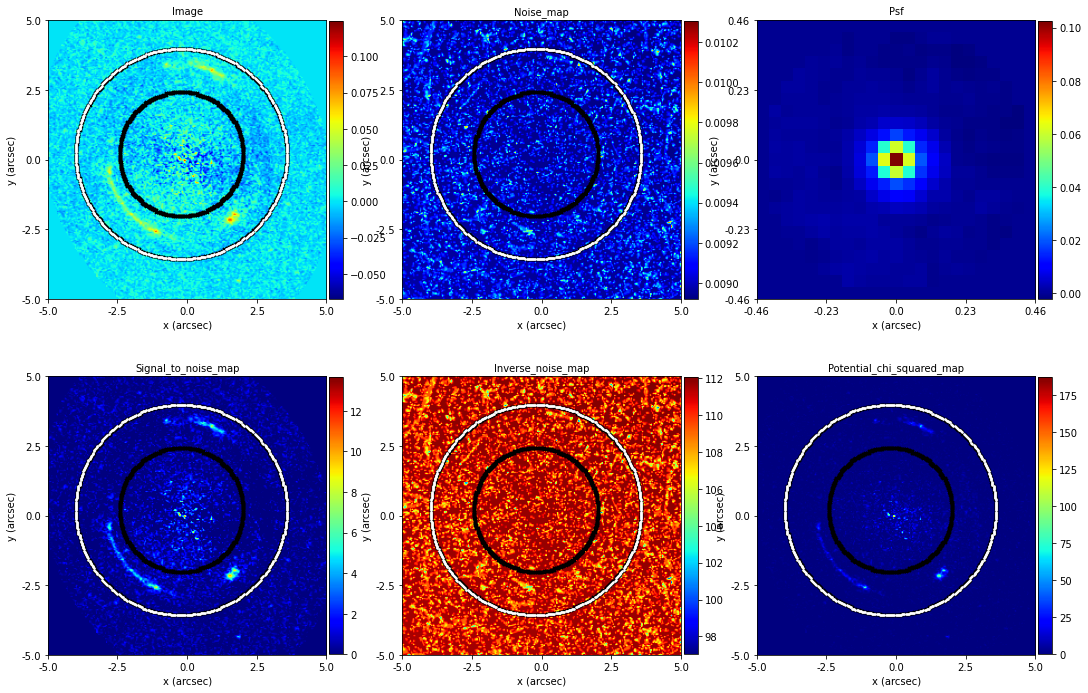

In [5]:
#Criando uma máscara e plotando tudo junto

mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d, 
    pixel_scales=imaging.pixel_scales, 
    sub_size=1,
    inner_radius=2.2,
    outer_radius=3.8, 
    centre=(0.2, -0.2)

)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),
)

In [6]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [43]:
#Lendo os dados MGE da fotometria e MGE DM.
surf_mge_lum, sigma_mge_lum, qObs_mge_lum = np.loadtxt('JAM Input.txt', unpack=True)   #Fotometria
pot_DM, sigma_DM, qObs_DM = np.loadtxt('pseudo-DM Input.txt', unpack=True) #DM

ml = np.array([9.5, 9.5, 8.5, 3.8, 3.4, 3.2, 2.8])                         #Mass-to-light ratio in M_sun/L_sun

#Convertendo surf_mge luminosity to mass
surf_mge_mass = surf_mge_lum*4.7

#Concatenando todas as componentes de matéria

MGE_total_surf = np.append(surf_mge_mass, pot_DM)
sigma_total_mass = np.append(sigma_mge_lum, sigma_DM)
qObs_total_mass = np. append(qObs_mge_lum, qObs_DM)

#Converting and computing some quantities
MGE_total_surf = MGE_total_surf*(u.solMass/u.pc**2)                                      #Surface Density in M_sun/pc²
sigma_total_mass_arc = sigma_total_mass*u.arcsec                                         #Sigma in arcsec
sigma_total_mass_pc = (sigma_total_mass_arc*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
TotalMass_MGE = 2*np.pi*MGE_total_surf*(sigma_total_mass_pc**2)*qObs_total_mass          #Total mass per gaussian component in M_sun


#Defining inputs for the integral below
i = np.deg2rad(90)*u.rad                                            #Inclination angle in rad
M0 = TotalMass_MGE                                                  #Mass per gaussian component in M_sun
q0 = np.sqrt(qObs_total_mass**2 - np.cos(i)**2)/np.sin(i)           #Deprojected axial ratio
sigma0 = (sigma_total_mass_arc).to(u.rad)                           #Sigma per gaussian in rad
M0.sum()

<Quantity 7.70348891e+11 solMass>

__Defining the MGE mass model for the lens galaxy and performing the ray tracing__

In [24]:
time = clock()

mass_profile = al.mp.MGE(centre=(0.0, 0.0))
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=2.1)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

print(lens_galaxy)

print(clock() - time)

Redshift: 0.035
Mass Profiles:
MGE
centre: (0.0, 0.0)
M: [3.95990609e+07 2.14493871e+08 2.59545468e+09 5.99318897e+09
 1.45617772e+10 2.46067706e+10 7.80698320e+10 8.73506049e+00
 2.83966750e+01 1.76385225e+00 7.07826134e+00 7.66908191e+01
 1.31404968e+02 1.69747682e+02 1.44414587e+02 4.29351308e+02
 9.83035624e+02 3.12192344e+02 1.11269486e+03 2.39700232e+03
 1.90149046e+01 5.45575342e+03 1.61883933e+03 5.72292282e+03
 1.26526261e+04 2.95386147e+04 5.93203445e+04 1.16642958e+05
 2.26768254e+05 9.51443542e+03 2.33777965e+05 3.45413635e+05
 4.67799326e+05 1.35488354e+06 1.69872652e+06 2.54268435e+06
 7.90298519e+06 3.38193012e+06 2.61609347e+07 1.06157766e+07
 1.30474811e+08 5.84078905e+08 3.74585641e+07 4.43014341e+09
 2.99983513e+08 1.72230327e+11]
sigma: [1.84714013e-07 8.54479265e-07 1.82864448e-06 3.41875579e-06
 6.40943079e-06 1.31994209e-05 3.44875412e-05 5.52687596e-10
 1.10537519e-09 1.25566743e-09 1.81805130e-09 2.03136932e-09
 3.19977030e-09 4.08697933e-09 5.62868684e-09 6.07

__Rectangular Inversion__

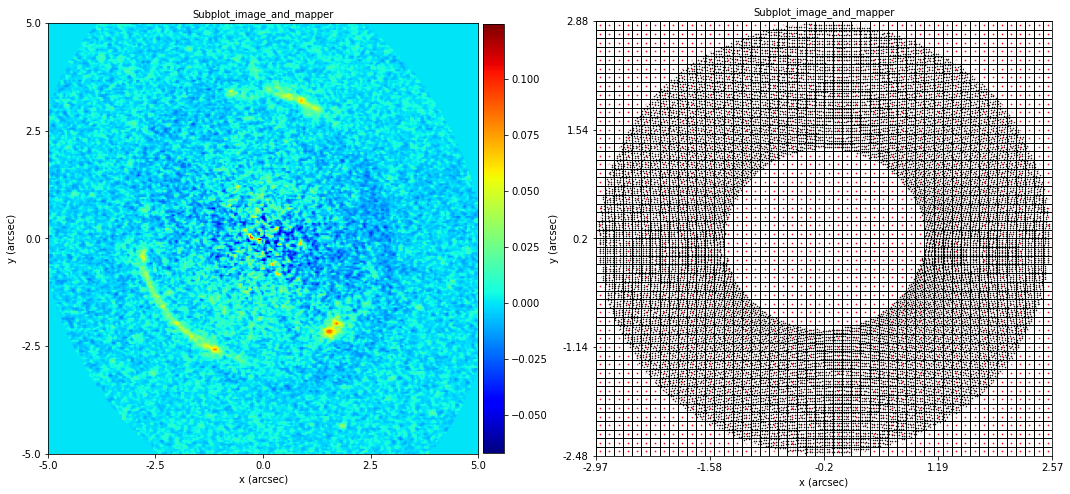

0.5672321299998657


In [25]:
time = clock()

rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=False, inversion_grid=True),
)

print(clock() - time)

In [26]:
time = clock()

inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=1.0),
)

print(clock() - time)

1.440372512999602


In [27]:
#Defining some output configs

sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/MGE/Rectangular/',
                                          filename='Rectangular Inversion Plots',
                                          format='png'),        
                              )

plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/MGE/Rectangular/',
                                          format='png'),         
                          )

include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

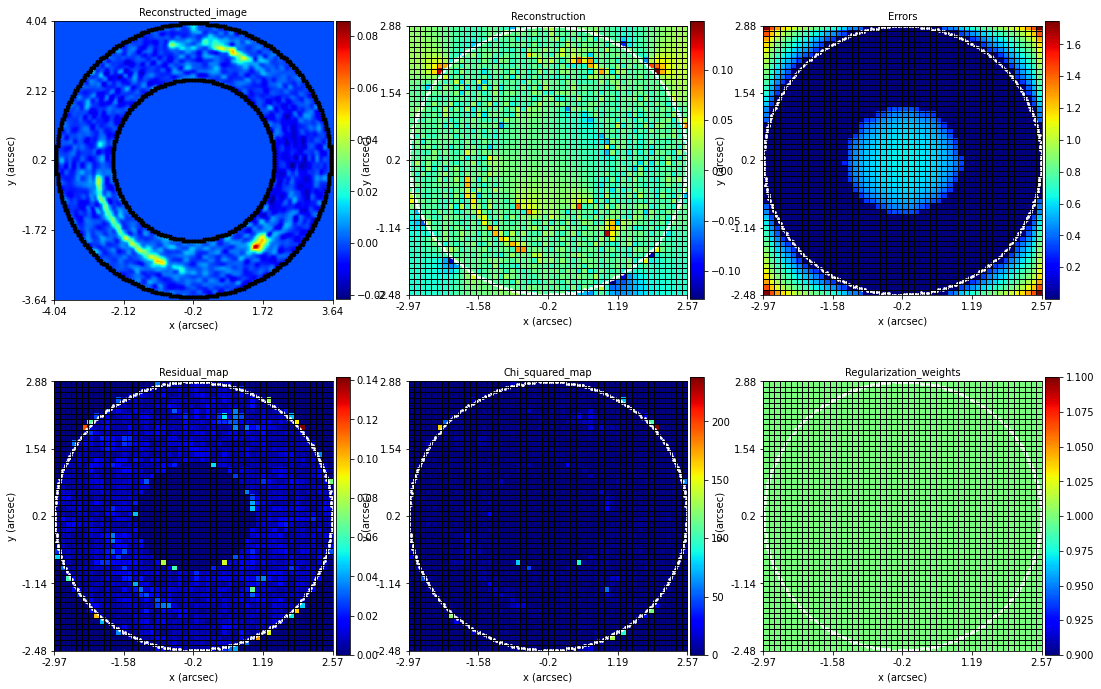

In [28]:
#Ploting Results
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                 sub_plotter=sub_plotter
                                )
 
aplt.Inversion.subplot_inversion(inversion=inversion,
                                include=(
                                     aplt.Include(
                                               inversion_grid=False, 
                                               inversion_pixelization_grid=False, 
                                               inversion_image_pixelization_grid=False)
                                         ),
                                )

In [29]:
#Save image results
aplt.Inversion.individuals(inversion=inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                               )

####################################################################################################################

In [30]:
#Here we define an usulfull function
def fit_masked_imaging_with_source_galaxy(masked_imaging, source_galaxy):
    mass_profile = al.mp.MGE(centre=(0.0, 0.0))
    mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)
    
    lens_galaxy = al.Galaxy(
        redshift=0.035,
        mass=mass_profile,
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

__Inversion with Constante Voronoi__

In [31]:
time = clock(
)
source_magnification = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(25, 25)),
    regularization=al.reg.Constant(coefficient=7),
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_magnification
)

print(clock() - time)

313.10621187200013


In [32]:
sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/MGE/ConstVoronoi/',
                                          filename='Constant Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/MGE/ConstVoronoi/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

In [33]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    sub_plotter=sub_plotter, 
                                    )



aplt.Inversion.individuals(inversion=fit.inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                           plot_regularization_weight_map=True,
                               )

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


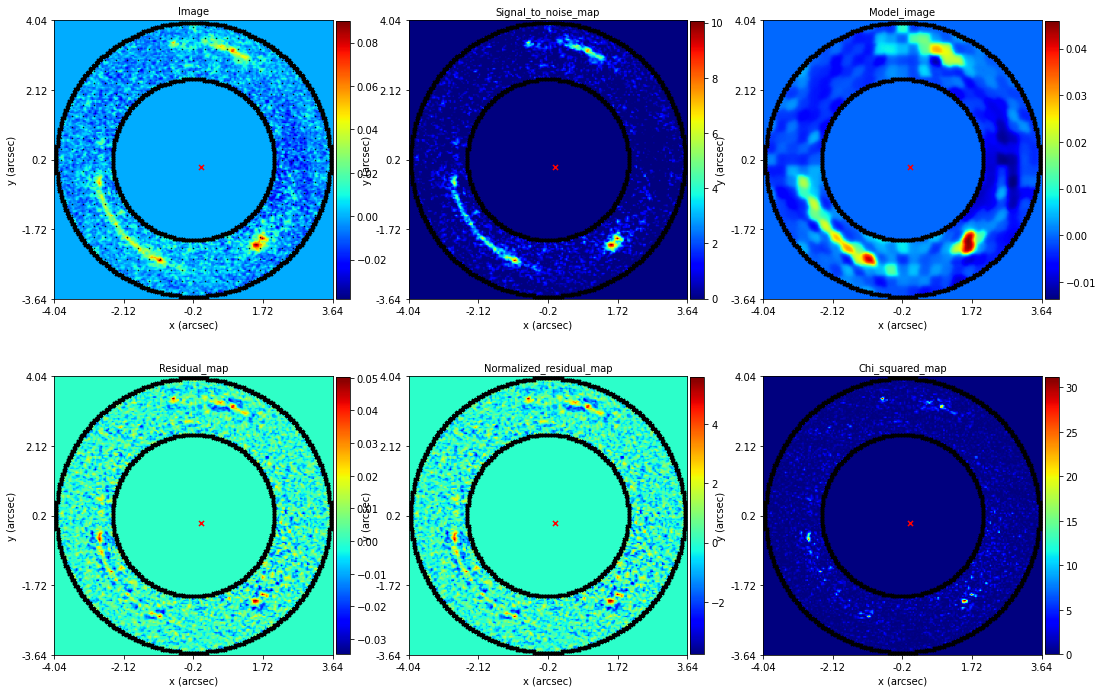

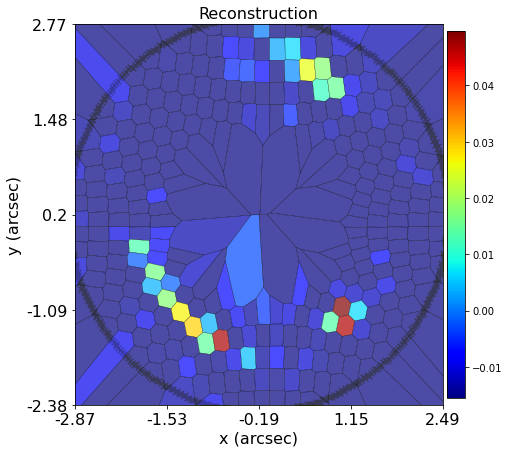

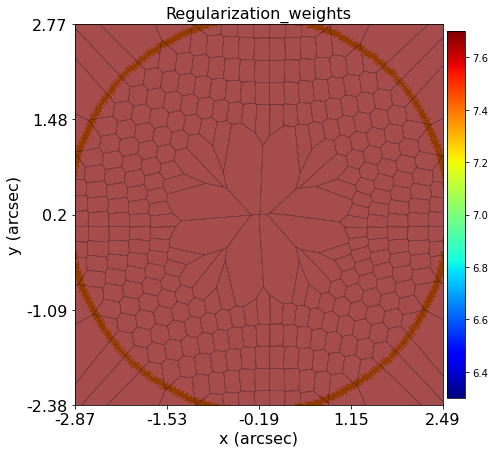

Evidence using adaptive _Regularization_=  63121.32824913769


In [34]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)
frist_log = fit.log_evidence

#################################################################################################################

__Inversion with Adaptative Voronoi__

In [44]:
time = clock()

hyper_image = fit.model_image.in_1d_binned

source_adaptive_regularization = al.Galaxy(
    redshift=2.1,
    pixelization=al.pix.VoronoiMagnification(shape=(50, 50)),
    regularization=al.reg.AdaptiveBrightness(
        inner_coefficient=0.00006, outer_coefficient=0.05, signal_scale=1.0
    ),
    hyper_galaxy_image=hyper_image,
)

fit = fit_masked_imaging_with_source_galaxy(
    masked_imaging=masked_imaging, source_galaxy=source_adaptive_regularization
)

print(clock() - time)

261.664488894


In [45]:
sub_plotter = aplt.SubPlotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/MGE/AdaptativeVoronoi/',
                                          filename='Adaptative Voronoi Plots',
                                          format='png'),        
                              )


plotter = aplt.Plotter(output=aplt.Output(path='/home/carlos/autolens_workspace/ESO325/Output/MGE/AdaptativeVoronoi/',
                                          format='png'),         
                       )


include = aplt.Include(inversion_grid=False,
                       inversion_pixelization_grid=False,
                       inversion_border=True,
                       inversion_image_pixelization_grid=False,
                      )

In [46]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    sub_plotter=sub_plotter, 
                                    )



aplt.Inversion.individuals(inversion=fit.inversion, 
                           plotter=plotter,
                           include=include,
                           plot_interpolated_reconstruction=True, 
                           plot_errors=True,
                           plot_reconstruction=True, 
                           plot_residual_map=True, 
                           plot_chi_squared_map=True,
                           plot_normalized_residual_map=True,
                           plot_regularization_weight_map=True,
                               )

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


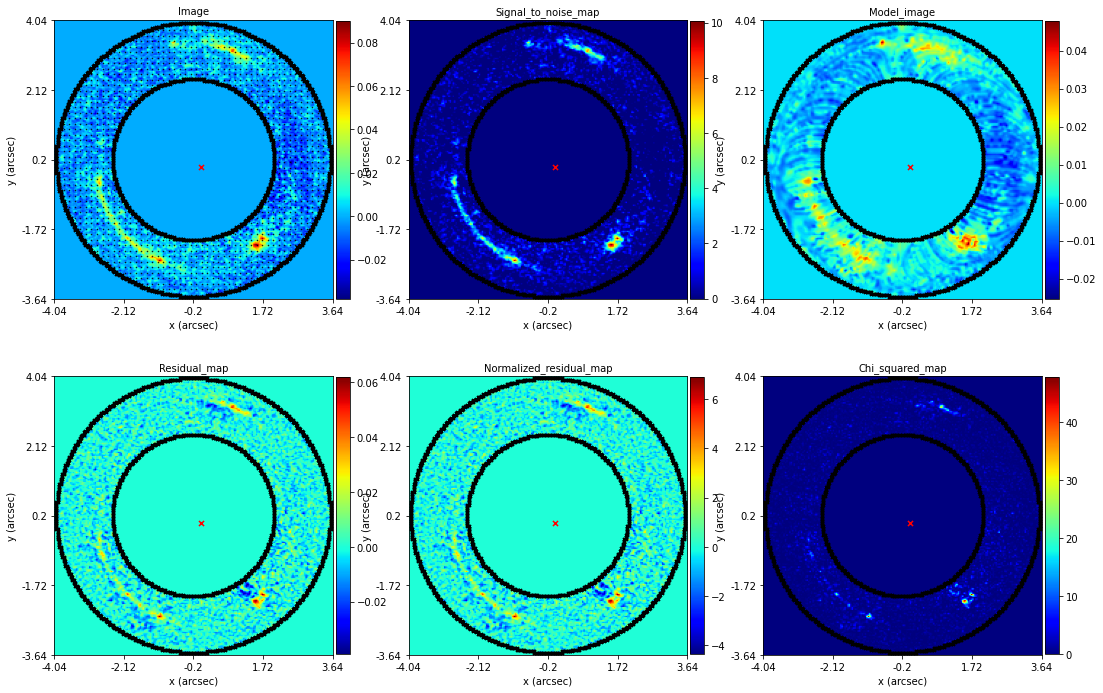

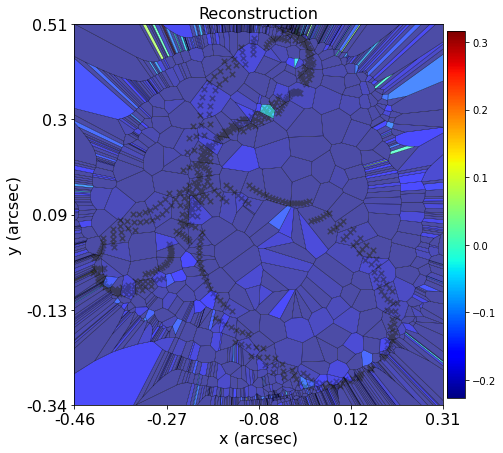

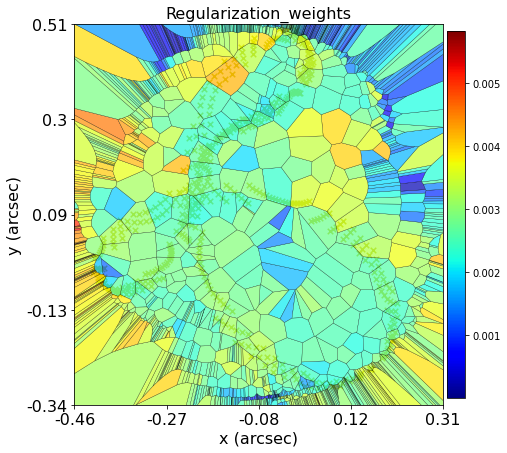

Evidence using adaptive _Regularization_=  52308.637603761585


In [47]:
aplt.FitImaging.subplot_fit_imaging(fit=fit, 
                                    include=aplt.Include(inversion_image_pixelization_grid=True, mask=True),
                                    )

aplt.Inversion.individuals(inversion=fit.inversion,
                           include=aplt.Include(inversion_pixelization_grid=False),
                           plot_reconstruction=True, 
                           plot_regularization_weight_map=True,
                           plotter=aplt.Plotter(figure=aplt.Figure(figsize=(7,7)))
                               
                           )

print("Evidence using adaptive _Regularization_= ", fit.log_evidence)